In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 5.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import random
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/Crawl_Stock_Prices.csv', index_col = 0)
# Drop duplicate rows in place and that rows are the days there is no exchange
df.drop_duplicates(keep='last',inplace=True)
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
#df = df.sort_values(by="Date1")
df.head()

,Date,Symbols,Close Prices
0,2022-05-27,AAA,12.65
1,2022-05-27,AAM,12.40
2,2022-05-27,AAT,15.10
3,2022-05-27,ABR,19.50
4,2022-05-27,ABS,13.90


In [ ]:
df.shape

(59800, 3)

# Extract all symbols

In [ ]:
# Number of stock symbols crawled.
symbols = [s for s in set(df.Symbols)]
#symbols = df.Symbols[:100]
print('Number of different stock symbols: ', len(symbols))

Number of different stock symbols:  117


In [ ]:
# Number of days from 27-5-2022 to 1-1-2020 crawled.
days = list(set(df.Date))
print('Number of days: ', len(days))

Number of days:  598


In [ ]:
five_symbols = symbols[:5] # Example of top 5 stock symbols
five_symbols

['BFC', 'BAF', 'BMP', 'DPR', 'DAG']

# EDA for 5 stock symbols chosen

Historical view of the closing price through years

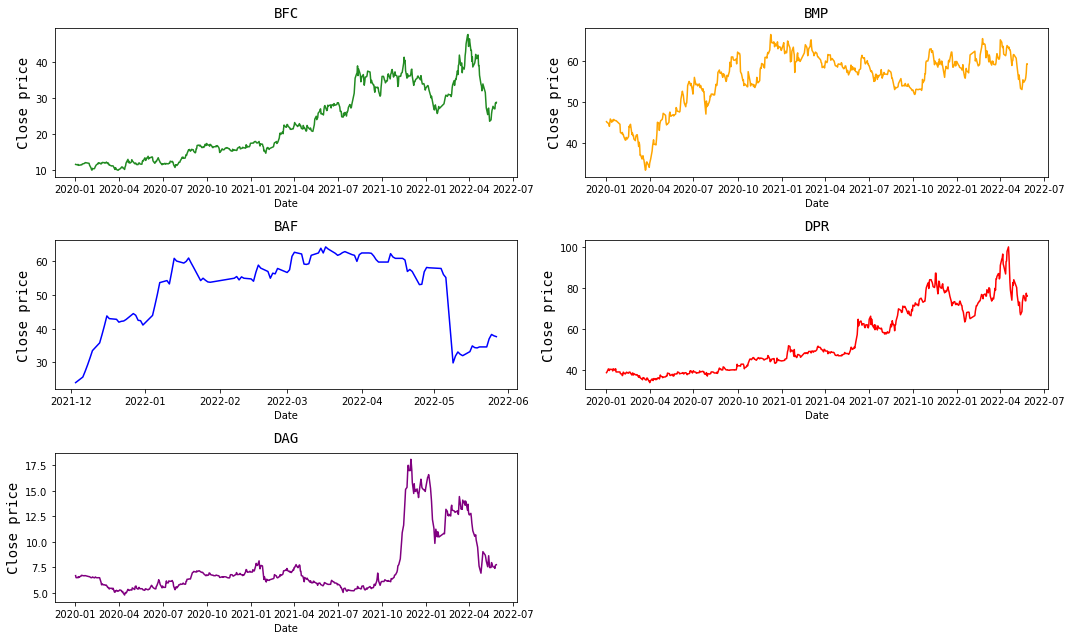

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_stock_close(symbol,idx, ax):
    if (idx == 0):
        linecolor = 'forestgreen' 
    elif (idx == 1):
        linecolor = 'blue'
    elif (idx == 2):
        linecolor = 'orange'
    elif (idx == 3):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x = "Date", y = "Close Prices", data = df.query("Symbols == @symbol"), ax=ax, color=linecolor)
    ax.set_title(symbol, size = 35, y = 1.03, fontname = 'monospace', fontsize=14)
    ax.set_ylabel('Close price', size = 14, fontname = 'monospace')

visualize_stock_close(five_symbols[0], 0, ax[0, 0])
visualize_stock_close(five_symbols[1], 1, ax[1, 0])
visualize_stock_close(five_symbols[2], 2, ax[0, 1])
visualize_stock_close(five_symbols[3], 3, ax[1, 1])
visualize_stock_close(five_symbols[4], 4, ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Decomposition of 5 symbol stock

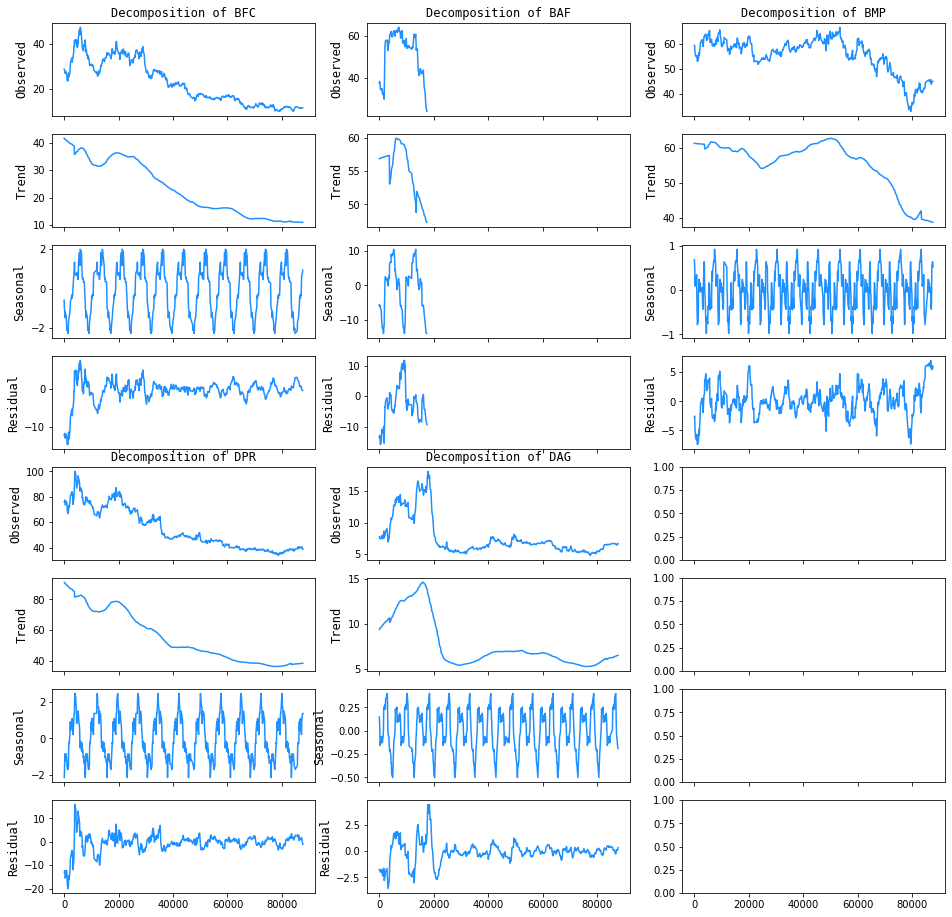

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=8, sharex=True, figsize=(16,16))

def visualize_decompose(symbol,ax1,ax2,ax3,ax4):

    res = seasonal_decompose(df[df.Symbols == symbol]['Close Prices'], freq=52, model='additive', extrapolate_trend='freq')

    ax1.set_title('Decomposition of {}'.format(symbol), fontsize=12,fontname = 'monospace')
    res.observed.plot(ax=ax1, legend=False, color='dodgerblue')
    ax1.set_ylabel('Observed', fontsize=12,fontname = 'monospace')

    res.trend.plot(ax=ax2, legend=False, color='dodgerblue')
    ax2.set_ylabel('Trend', fontsize=12,fontname = 'monospace')

    res.seasonal.plot(ax=ax3, legend=False, color='dodgerblue')
    ax3.set_ylabel('Seasonal', fontsize=12,fontname = 'monospace')
    
    res.resid.plot(ax=ax4, legend=False, color='dodgerblue')
    ax4.set_ylabel('Residual', fontsize=12,fontname = 'monospace')


visualize_decompose(five_symbols[0],ax[0, 0],ax[1, 0],ax[2, 0],ax[3, 0])
visualize_decompose(five_symbols[1], ax[0, 1],ax[1, 1],ax[2, 1],ax[3, 1])
visualize_decompose(five_symbols[2], ax[0, 2],ax[1, 2],ax[2, 2],ax[3, 2])
visualize_decompose(five_symbols[3], ax[4, 0],ax[5, 0],ax[6, 0],ax[7, 0])
visualize_decompose(five_symbols[4], ax[4, 1],ax[5, 1],ax[6, 1],ax[7, 1])

plt.show()

Correlation map for 5 symbol

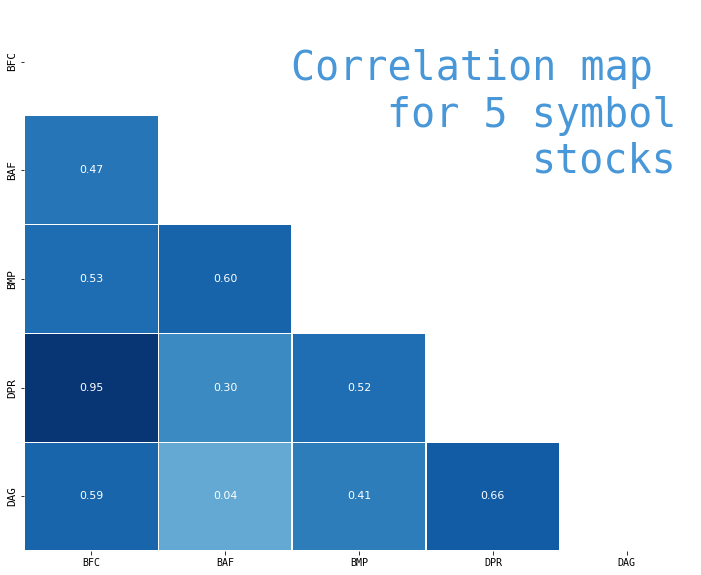

In [ ]:
corr_map = pd.DataFrame()
for stock in five_symbols:
    corr_map[stock] = df.query("Symbols == @stock")['Close Prices'].reset_index()['Close Prices']

matrix = np.triu(corr_map.corr())
plt.figure(figsize = (12, 10))
sns.heatmap(corr_map.corr(), annot = True, cmap = 'Blues', fmt=".2f", mask = matrix, vmin = -1, vmax = 1, linewidths = 0.1, linecolor = 'white', cbar = False, annot_kws = {'fontsize': 11})
plt.xticks(size = 10, fontname = 'monospace')
plt.yticks(size = 11, fontname = 'monospace')
plt.figtext(0.88, 0.65, '''Correlation map 
for 5 symbol
stocks''', fontsize = 40, fontname = 'monospace', ha = 'right', color = '#4897d8')
plt.show()

# Task 2. Pre-processing

## An image that includes the daily prices of 5 stock symbols above.

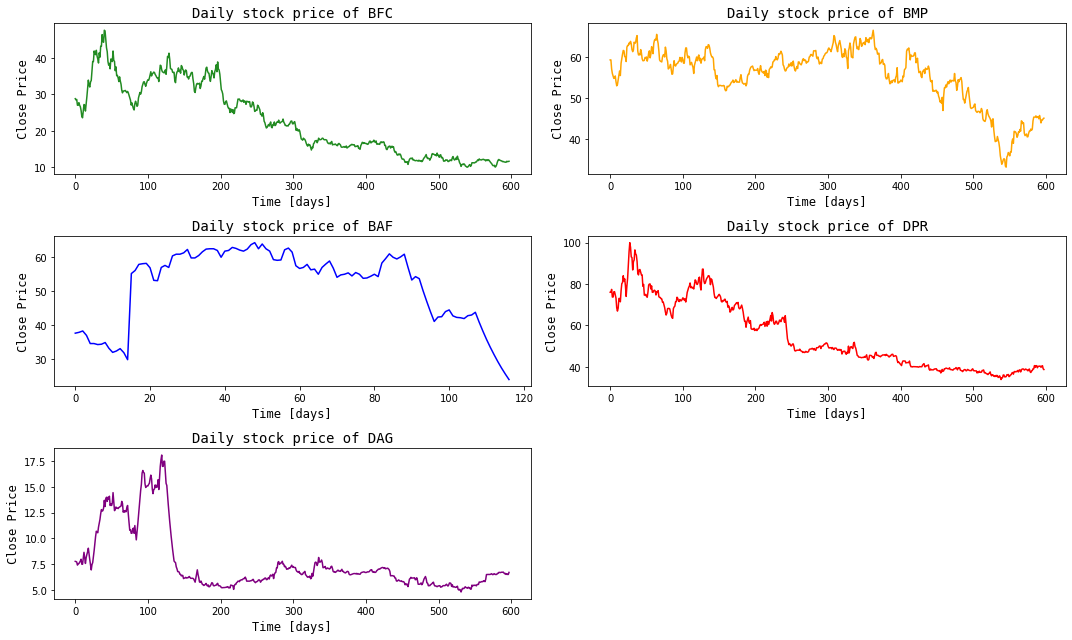

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_daily_close(symbol,idx, ax):
    if (idx == 0):
        linecolor = 'forestgreen' 
    elif (idx == 1):
        linecolor = 'blue'
    elif (idx == 2):
        linecolor = 'orange'
    elif (idx == 3):
        linecolor = 'red'
    else:
        linecolor = 'purple'

    ax.plot(df[df.Symbols == symbol]['Close Prices'].values, color=linecolor)

    ax.set_title('Daily stock price of {}'.format(symbol), fontsize=14,fontname = 'monospace')
    ax.set_ylabel(ylabel='Close Price', fontsize=12,fontname = 'monospace')

    ax.set_xlabel(xlabel='Time [days]', fontsize=12,fontname = 'monospace')

visualize_daily_close(five_symbols[0], 0, ax[0, 0])
visualize_daily_close(five_symbols[1], 1, ax[1, 0])
visualize_daily_close(five_symbols[2], 2, ax[0, 1])
visualize_daily_close(five_symbols[3], 3, ax[1, 1])
visualize_daily_close(five_symbols[4], 4, ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

## Normalize data by TimeSeriesScalerMeanVariance## 

In [ ]:
# Normilize data of 5 symbols above
normilized_of_5_symbols = []
for symbol in five_symbols:
    symbol_data = df[df.Symbols == symbol]['Close Prices'].values
    normilzed_data = TimeSeriesScalerMeanVariance().fit_transform([symbol_data])
    normilized_of_5_symbols.append(normilzed_data.reshape(-1,1))

## An image that includes the daily prices after normalizing of 5 stock symbols above.

Black line is the close price after normalized by TimeSeriesScalerMeanVariance

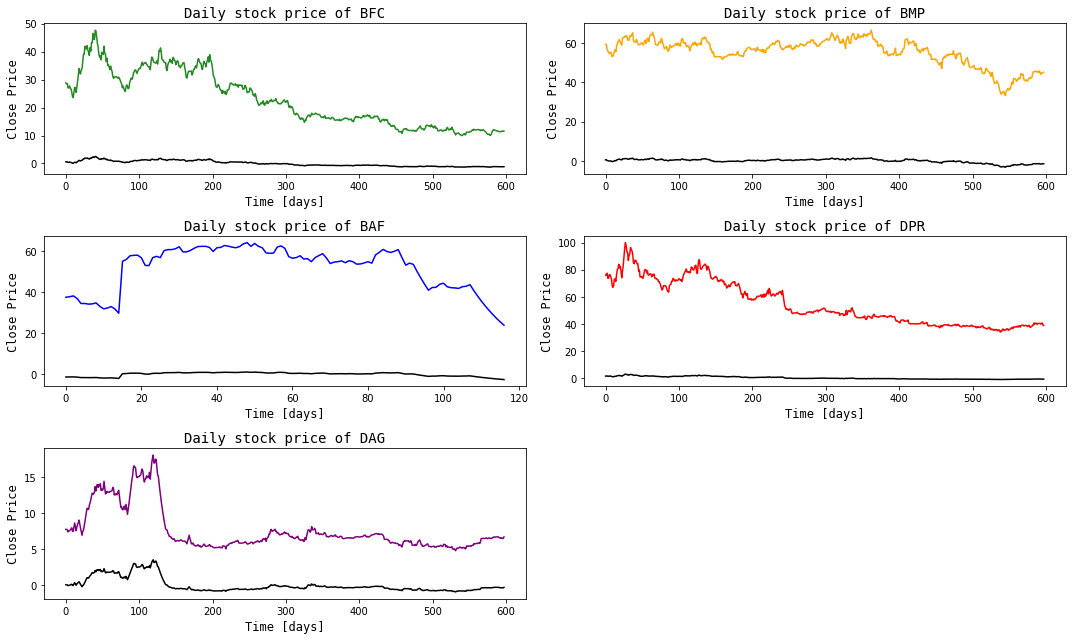

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_normilized_close(symbol,idx, ax):
    if (idx == 0):
        linecolor = 'forestgreen' 
    elif (idx == 1):
        linecolor = 'blue'
    elif (idx == 2):
        linecolor = 'orange'
    elif (idx == 3):
        linecolor = 'red'
    else:
        linecolor = 'purple'

    ax.plot(df[df.Symbols == symbol]['Close Prices'].values, color = linecolor)
    ax.plot(normilized_of_5_symbols[idx], color='black')

    ax.set_title('Daily stock price of {}'.format(symbol), fontsize=14,fontname = 'monospace')
    ax.set_ylabel(ylabel='Close Price', fontsize=12,fontname = 'monospace')

    ax.set_xlabel(xlabel='Time [days]', fontsize=12,fontname = 'monospace')

visualize_normilized_close(five_symbols[0], 0, ax[0, 0])
visualize_normilized_close(five_symbols[1], 1, ax[1, 0])
visualize_normilized_close(five_symbols[2], 2, ax[0, 1])
visualize_normilized_close(five_symbols[3], 3, ax[1, 1])
visualize_normilized_close(five_symbols[4], 4, ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

# Task 3. Using time series k-means with three variants:

In [ ]:
# Choose stock symbols that have stock exchanges more than 90 day
stock_symbols = [symbol for symbol in symbols if len(df[df.Symbols == symbol]['Close Prices']) > 90]
len(stock_symbols)

111

In [ ]:
#Only get 100 stock symbols
stock_symbols = stock_symbols[:100]

In [ ]:
#Get daily stock prices of 100 stock symbols but for the last 3 months.

dataset = [df[df.Symbols == symbol]['Close Prices'][:90].values.tolist() for symbol in stock_symbols] 
# Convert to time series dataset
formatted_dataset = to_time_series_dataset(dataset)
# Shuffle symbols 
np.random.shuffle(formatted_dataset)
# Normilize data
formatted_dataset = TimeSeriesScalerMeanVariance().fit_transform(formatted_dataset)
sz = formatted_dataset.shape[1]
formatted_dataset.shape

(100, 90, 1)

## Euclidean k-means

Using elbow method for choosing the best k.

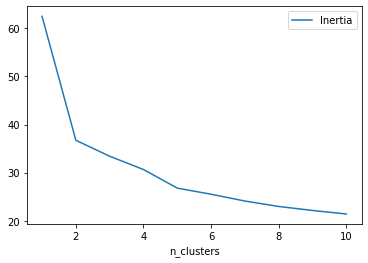

In [ ]:
elbow_data = []
for n_clusters in range (1,11,1):
    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=42)
    y_pred = km.fit_predict(formatted_dataset)
    elbow_data.append((n_clusters, km.inertia_))

pd.DataFrame(elbow_data,columns=['n_clusters', 'Inertia']).plot(x='n_clusters',y='Inertia')

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 2.

Euclidean k-means


<Figure size 432x288 with 0 Axes>

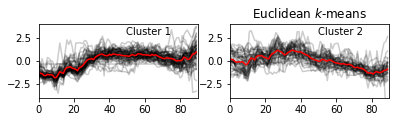

In [ ]:
# Euclidean k-means
EUCLID_N_CLUSTER = 2
print("Euclidean k-means")

km = TimeSeriesKMeans(n_clusters=EUCLID_N_CLUSTER, verbose=False, random_state=43)
y_pred = km.fit_predict(formatted_dataset)

plt.figure()
plt.subplots(figsize = (20, 16))
for yi in range(EUCLID_N_CLUSTER):
    plt.subplot(10, 6, yi + 1)
    for xx in formatted_dataset[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

## DBA k-means

Choosing best k

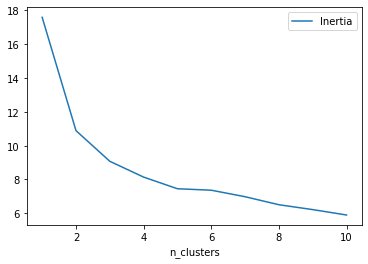

In [ ]:
elbow_data = []
for n_clusters in range (1,11,1):
    dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=43)
    
    y_pred = dba_km.fit_predict(formatted_dataset)
    elbow_data.append((n_clusters, dba_km.inertia_))

pd.DataFrame(elbow_data,columns=['n_clusters', 'Inertia']).plot(x='n_clusters',y='Inertia')

DBA k-means


<Figure size 432x288 with 0 Axes>

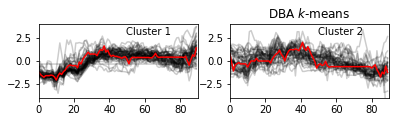

In [ ]:
# DBA-k-means
DBA_N_CLUSTER = 2
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=DBA_N_CLUSTER,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=43)
y_pred = dba_km.fit_predict(formatted_dataset)

plt.figure()
plt.subplots(figsize = (20, 16))
for yi in range(DBA_N_CLUSTER):
    plt.subplot(10, 6, yi + 1)
    for xx in formatted_dataset[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

## Soft-DTW-k-means
Choosing best k

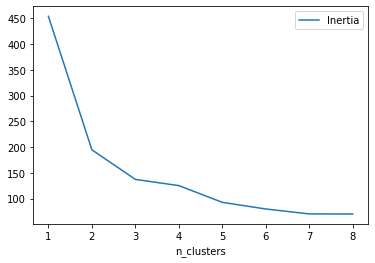

In [ ]:
elbow_data = []
for n_clusters in range (1,9,1):
    sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=False,
                           random_state=43)
    
    y_pred = sdtw_km.fit_predict(formatted_dataset)
    elbow_data.append((n_clusters, sdtw_km.inertia_))

pd.DataFrame(elbow_data,columns=['n_clusters', 'Inertia']).plot(x='n_clusters',y='Inertia')

Soft-DTW k-means


<Figure size 432x288 with 0 Axes>

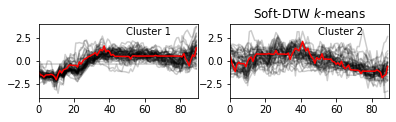

In [ ]:
# Soft-DTW-k-means
DTW_N_CLUSTER = 2
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=DTW_N_CLUSTER,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=False,
                           random_state=43)
y_pred = sdtw_km.fit_predict(formatted_dataset)

plt.figure()
plt.subplots(figsize = (20, 16))
for yi in range(DTW_N_CLUSTER):
    plt.subplot(10, 6, yi + 1)
    for xx in formatted_dataset[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

# Task 4. Stock Prices Prediction

**This is Univariate Time Series Prediction**

Univariate time series: Only one variable is varying over time. 

Choose stock symbol: CDC

In [ ]:
symbol_stock = 'CDC'

In [ ]:
get_size = df[df.Symbols == symbol_stock][['Date', 'Close Prices']].copy()
get_size = get_size.set_index('Date')

In [ ]:
train_size = len(get_size['2020-01-01':'2021-12-31']) # Calculate number of days from 2020 to 2021
test_size = len(days) - train_size

univariate_df = df[df.Symbols == symbol_stock][['Date', 'Close Prices']].copy()
univariate_df.columns = ['ds', 'y']
univariate_df = univariate_df.sort_values(by="ds")

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

502 96


## Prophet
Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet(changepoint_range=1,changepoint_prior_scale=0.75)
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('MAE: {}'.format(score_mae))
print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.5891072437709689
RMSE: 0.6890331699944784


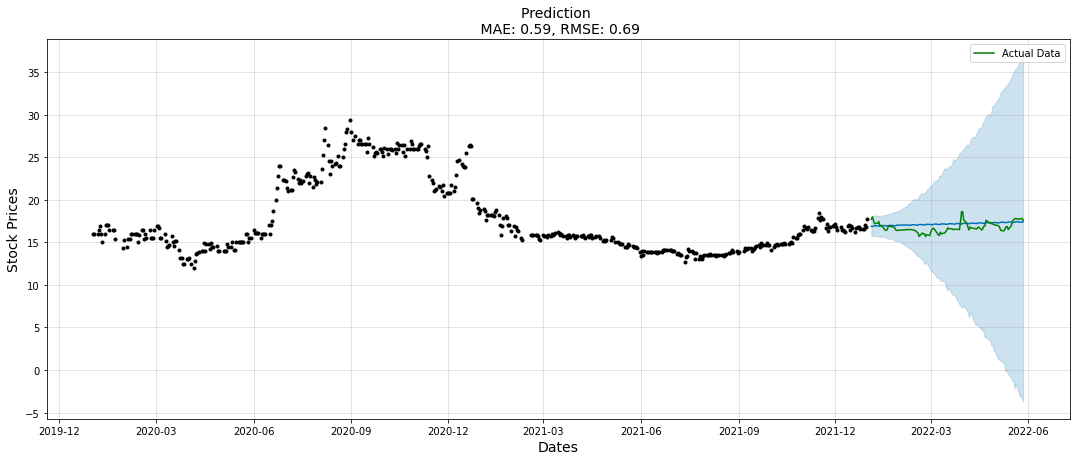

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='green', label='Actual Data')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Dates', fontsize=14)
ax.set_ylabel(ylabel='Stock Prices', fontsize=14)

plt.show()

## LSTM
LSTM which is long short term memory is the type of RNN which can hold memory for longer period of time. They are a good fit for time series preditiction, or forecasting problems.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/1200px-LSTM_Cell.svg.png)

**Normilize data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Convert the dataframe to a numpy array
dataset = univariate_df.y.values.reshape(-1,1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [ ]:
# Defines the rolling window
look_back = 60
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

398 96


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            92672     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 144,193
Trainable params: 144,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
398/398 [==============================] - 9s 6ms/step - loss: 0.0146 - val_loss: 0.0018
Epoch 2/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0072 - val_loss: 8.3070e-04
Epoch 3/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 4/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0055 - val_loss: 6.9810e-04
Epoch 5/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 6/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 9.3571e-04
Epoch 7/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0010
Epoch 8/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 5.4194e-04
Epoch 9/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 10/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0036 - 

In [ ]:
# Lets predict with the model
test_predict = model.predict(x_test)

# invert scaler predictions
test_predict = scaler.inverse_transform(test_predict)
y_test_invert = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test_invert[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test_invert[0], test_predict[:,0])

print('MAE: {}'.format(score_mae))
print('RMSE: {}'.format(score_rmse))

MAE: 0.4134726365407307
RMSE: 0.49894858611084775


Seems this model worked very good

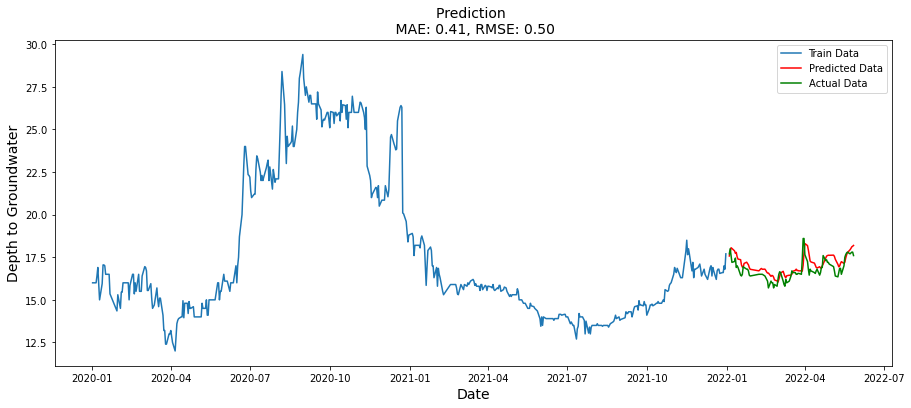

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train_plot = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train_plot, ax=ax, label='Train Data') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='red', label='Predicted Data') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test_invert[0], ax=ax, color='green', label='Actual Data') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

## GRU
The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. GRU’s got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a reset gate and update gate.

![](https://miro.medium.com/max/1400/1*yBXV9o5q7L_CvY7quJt3WQ.png)

In [ ]:
from keras.layers import GRU,Dropout
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
modelGRU.add(Dropout(0.1))

modelGRU.add(GRU(64, return_sequences=False))
modelGRU.add(Dense(32))
modelGRU.add(Dense(1))

modelGRU.compile(optimizer='adam', loss='mean_squared_error')
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 128)            69888     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 109,249
Trainable params: 109,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the model
modelGRU.fit(x_train, y_train, batch_size=1, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
398/398 [==============================] - 4s 6ms/step - loss: 0.0129 - val_loss: 0.0087
Epoch 2/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0089 - val_loss: 6.9041e-04
Epoch 3/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 4/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0058 - val_loss: 0.0075
Epoch 5/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 9.6171e-04
Epoch 6/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 8.8851e-04
Epoch 7/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 8/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 9/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 10/10
398/398 [==============================] - 2s 4ms/step - loss: 0.0043 - val_

In [ ]:
# Lets predict with the GRU model
test_predict = modelGRU.predict(x_test)

# invert scaler predictions
test_predict = scaler.inverse_transform(test_predict)
y_test_invert = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test_invert[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test_invert[0], test_predict[:,0])

print('MAE: {}'.format(score_mae))
print('RMSE: {}'.format(score_rmse))

MAE: 0.2841417809327444
RMSE: 0.40711803336025837


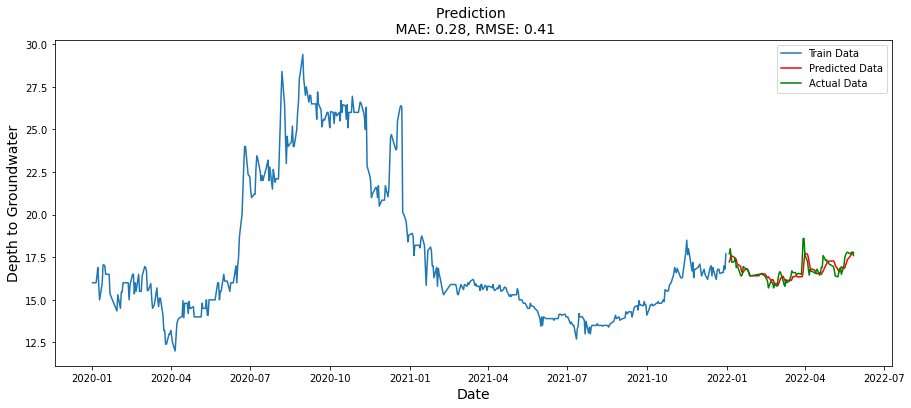

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train_plot = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train_plot, ax=ax, label='Train Data') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='red', label='Predicted Data') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test_invert[0], ax=ax, color='green', label='Actual Data') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()